# Recurrent Neural Network

## Part 0 - Get the data
Currently I use the data provided by Binance, obtained with FIrst Steps (Notebook) function, because I dont like YahooFinancials, but this is the code to download the data from it...

In [100]:
import yfinance as yf #docs at https://pypi.org/project/yfinance/

In [136]:
#get the data
stock = "BTC-USD"
period = "1d" # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max ( default '1mo')
interval = "5m" # 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo (default '1d')
data = yf.download(tickers=stock, period = period, interval = interval)

[*********************100%***********************]  1 of 1 completed


In [137]:
#save it
data.to_csv("data/yf_"+"_".join([stock,period,interval]))

## Part 1 - Data Preprocessing

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lib.TechnicalIndicators import *
from pickle import dump

### Importing the training set

In [2]:
#Load data
#stock = "BTC-USD"
#period = "1d" 
#interval = "1m" 
#dataset_location = "../data/yf_"+"_".join([stock,period,interval])
#dataset = pd.read_csv(dataset_location, index_col = "Datetime", parse_dates = ["Datetime"])
dataset = pd.read_csv("data/dic19_1m.csv", index_col = "Date", parse_dates = ["Date"]).tail(70000)

### Add indicators to dataset 

In [3]:
strategies = [
    SMA(
        data = dataset,
        SMA_S = 5,
        SMA_L = 13,
        column = "Close"
    ),
    EWMA(
        data = dataset,
        approx_avg_period_s = 5,
        approx_avg_period_l = 8,
        column = "Close"
    ),
    BollingerBands(
        data = dataset,
        dev = 1.5, 
        periods = 10,
        column = "Close"
    ),
    MACD(
        data = dataset,
        fast =12,
        slow =26, 
        signal = 9,
        column = "Close"
    ),
    RSI(
        data = dataset,
        length = 14,
        column = "Close"
    ),
    Hammer(
        data = dataset
    ),
    Doji(
        data = dataset
    ),
    EBSW(
        data = dataset,
        column = "Close"
    ),
    ADX(
        data = dataset
    ),
    KVO(
        data = dataset
    ),
    OBV(
        data = dataset
    )
]
for strategy in strategies:
    strategy.calculate() #add columns to data    

put the desired outcomes, 1, 0 or -1

In [4]:
predict_period = 1 #this is the "n" period after to predict (1 is next period...)
#position can be either -1, 0 or 1
dataset["position"] = np.where( dataset["Close"] - dataset["Close"].shift(-predict_period) < 0, 1 , np.nan)
dataset["position"] = np.where( dataset["Close"] - dataset["Close"].shift(-predict_period) == 0, 0 , dataset.position)
dataset["position"] = np.where( dataset["Close"] - dataset["Close"].shift(-predict_period) > 0, -1 , dataset.position)
#drop nas after adding all...
dataset.dropna(inplace = True)
dataset

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Close|SMA|5,...,CDL_DRAGONFLYDOJI,CDL_GRAVESTONEDOJI,Close_EBSW,Close_High_Low_ADX_14,Close_High_Low_DMP_14,Close_High_Low_DMN_14,Close_High_Low_Volume_KVO_34_55_13,Close_High_Low_Volume_KVOs_34_55_13,Close_Volume_OBV,position
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31 17:44:00,20644.9,20644.9,20511.2,20644.9,55.620,1.145247e+06,19,33.167,6.847082e+05,20591.44,...,1.0,0.0,-0.060137,40.645407,0.828920,1.059400,-0.186222,1.851204,-341.934,-1.0
2022-10-31 17:45:00,20640.0,20644.9,20511.2,20511.2,81.507,1.676019e+06,27,31.524,6.508073e+05,20589.68,...,0.0,0.0,-0.849498,38.576159,0.768952,0.982758,-1.728583,1.339806,-423.441,1.0
2022-10-31 17:46:00,20641.2,20644.9,20511.2,20640.0,76.327,1.569895e+06,18,32.516,6.712462e+05,20589.48,...,1.0,0.0,-0.806580,36.660015,0.713373,0.911725,0.254813,1.184807,-347.114,-1.0
2022-10-31 17:47:00,20640.0,20644.9,20511.2,20511.2,92.885,1.911817e+06,28,49.829,1.028663e+06,20563.72,...,0.0,0.0,-0.912728,34.885292,0.661854,0.845882,-1.568407,0.791490,-439.999,1.0
2022-10-31 17:48:00,20512.0,20644.9,20511.2,20640.0,29.183,6.003891e+05,32,13.441,2.774797e+05,20589.46,...,0.0,0.0,-0.916931,33.241246,0.614094,0.784842,-0.607106,0.591691,-410.816,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19 07:12:00,16787.0,16789.0,16752.5,16752.5,50.109,8.403579e+05,48,24.940,4.187141e+05,16759.84,...,0.0,0.0,-0.999787,20.527413,0.386763,0.339025,-1.823536,-2.395652,-1799.901,0.0
2022-12-19 07:13:00,16789.0,16789.0,16752.5,16752.5,43.053,7.218774e+05,44,17.290,2.902818e+05,16752.54,...,0.0,0.0,-0.985028,19.530983,0.359767,0.315361,-1.523897,-2.271116,-1799.901,0.0
2022-12-19 07:14:00,16789.0,16790.0,16752.5,16752.5,97.514,1.635953e+06,60,61.336,1.029771e+06,16752.52,...,0.0,0.0,-0.959997,20.165473,0.525151,0.292753,0.841226,-1.826496,-1799.901,1.0


split into training and test sets

In [5]:
total_size = dataset.shape[0]
test_size = min(int(total_size*0.2), 1000) #limits max number of test records
train_size = total_size - test_size
dataset_train = dataset.iloc[:train_size]
dataset_test = dataset.iloc[train_size:]
dataset_test

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Close|SMA|5,...,CDL_DRAGONFLYDOJI,CDL_GRAVESTONEDOJI,Close_EBSW,Close_High_Low_ADX_14,Close_High_Low_DMP_14,Close_High_Low_DMN_14,Close_High_Low_Volume_KVO_34_55_13,Close_High_Low_Volume_KVOs_34_55_13,Close_Volume_OBV,position
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-18 14:37:00,16711.0,16785.0,16711.0,16711.2,50.079,8.388999e+05,228,32.476,5.446770e+05,16714.24,...,0.0,1.0,-0.950575,87.135056,11.347762,0.551486,6.029592,4.954774,-285.543,-1.0
2022-12-18 14:38:00,16711.2,16784.0,16710.0,16710.0,47.920,8.018009e+05,191,15.925,2.671444e+05,16710.64,...,0.0,1.0,-0.969301,87.272046,10.525243,0.609462,4.358165,4.869544,-333.463,1.0
2022-12-18 14:39:00,16712.0,16796.2,16709.0,16715.0,81.626,1.367112e+06,313,40.059,6.724111e+05,16711.44,...,0.0,1.0,-0.817173,87.480262,10.817165,0.558125,5.605622,4.974698,-251.837,1.0
2022-12-18 14:40:00,16747.0,16789.0,16716.0,16716.0,53.826,9.018299e+05,246,28.724,4.821669e+05,16712.64,...,0.0,0.0,-0.007131,87.673605,10.043960,0.518230,6.132636,5.140118,-198.011,1.0
2022-12-18 14:41:00,16716.0,16796.2,16710.0,16796.2,138.618,2.325230e+06,301,111.642,1.874343e+06,16729.68,...,0.0,0.0,0.612241,87.899550,9.904784,0.475585,8.416244,5.608136,-59.393,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19 07:12:00,16787.0,16789.0,16752.5,16752.5,50.109,8.403579e+05,48,24.940,4.187141e+05,16759.84,...,0.0,0.0,-0.999787,20.527413,0.386763,0.339025,-1.823536,-2.395652,-1799.901,0.0
2022-12-19 07:13:00,16789.0,16789.0,16752.5,16752.5,43.053,7.218774e+05,44,17.290,2.902818e+05,16752.54,...,0.0,0.0,-0.985028,19.530983,0.359767,0.315361,-1.523897,-2.271116,-1799.901,0.0
2022-12-19 07:14:00,16789.0,16790.0,16752.5,16752.5,97.514,1.635953e+06,60,61.336,1.029771e+06,16752.52,...,0.0,0.0,-0.959997,20.165473,0.525151,0.292753,0.841226,-1.826496,-1799.901,1.0


cols to use (the predicted one is "position")

In [6]:
#cols = ["Open", "Volume"]
#cols = dataset_train.columns #use all
#training_set = dataset_train[cols].loc[:].values
training_set = dataset_train.drop(["position"], axis=1)
training_set

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Close|SMA|5,...,CDL_DOJI_10_0.1,CDL_DRAGONFLYDOJI,CDL_GRAVESTONEDOJI,Close_EBSW,Close_High_Low_ADX_14,Close_High_Low_DMP_14,Close_High_Low_DMN_14,Close_High_Low_Volume_KVO_34_55_13,Close_High_Low_Volume_KVOs_34_55_13,Close_Volume_OBV
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31 17:44:00,20644.9,20644.9,20511.2,20644.9,55.620,1.145247e+06,19,33.167,6.847082e+05,20591.44,...,1.0,1.0,0.0,-0.060137,40.645407,0.828920,1.059400,-0.186222,1.851204,-341.934
2022-10-31 17:45:00,20640.0,20644.9,20511.2,20511.2,81.507,1.676019e+06,27,31.524,6.508073e+05,20589.68,...,0.0,0.0,0.0,-0.849498,38.576159,0.768952,0.982758,-1.728583,1.339806,-423.441
2022-10-31 17:46:00,20641.2,20644.9,20511.2,20640.0,76.327,1.569895e+06,18,32.516,6.712462e+05,20589.48,...,1.0,1.0,0.0,-0.806580,36.660015,0.713373,0.911725,0.254813,1.184807,-347.114
2022-10-31 17:47:00,20640.0,20644.9,20511.2,20511.2,92.885,1.911817e+06,28,49.829,1.028663e+06,20563.72,...,0.0,0.0,0.0,-0.912728,34.885292,0.661854,0.845882,-1.568407,0.791490,-439.999
2022-10-31 17:48:00,20512.0,20644.9,20511.2,20640.0,29.183,6.003891e+05,32,13.441,2.774797e+05,20589.46,...,0.0,0.0,0.0,-0.916931,33.241246,0.614094,0.784842,-0.607106,0.591691,-410.816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-18 14:32:00,16720.0,16799.0,16710.0,16710.0,149.793,2.508045e+06,237,76.866,1.289314e+06,16723.12,...,0.0,0.0,0.0,-0.055154,86.562059,9.383356,0.685019,5.175756,2.773183,-338.825
2022-12-18 14:33:00,16712.0,16789.0,16709.0,16728.0,109.599,1.836179e+06,233,75.437,1.265220e+06,16727.52,...,0.0,0.0,0.0,-0.916665,86.413385,8.660365,0.728551,7.026973,3.380868,-229.226
2022-12-18 14:34:00,16728.0,16740.0,16709.0,16711.0,35.562,5.943652e+05,147,0.115,1.923620e+03,16712.72,...,0.0,0.0,0.0,-0.871733,86.275329,8.390577,0.705855,5.585136,3.695763,-264.788


### Feature Scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
dump(sc, open('models/scaler_dic19_1m.pkl', 'wb'))
training_set_scaled

array([[0.75789078, 0.75067077, 0.76961318, ..., 0.43799341, 0.40857215,
        0.63649879],
       [0.75715466, 0.75067077, 0.76961318, ..., 0.43232343, 0.40498807,
        0.63508545],
       [0.75733494, 0.75067077, 0.76961318, ..., 0.43961473, 0.40390177,
        0.63640896],
       ...,
       [0.16945842, 0.16206928, 0.23865382, ..., 0.45920991, 0.42149956,
        0.6378365 ],
       [0.16720499, 0.16960598, 0.23879346, ..., 0.46663005, 0.42541206,
        0.63574982],
       [0.16705476, 0.17054053, 0.23879346, ..., 0.46773932, 0.42906775,
        0.63660824]])

### Creating a data structure with "n" timesteps and 1 output

In [8]:
timestamps = 60
X_train = []
y_train = []
for i in range(timestamps, train_size+1): #use all available datset (+1 because one method dont include upper bound)
    X_train.append(training_set_scaled[i-timestamps:i]) #doesnt include upper bound
    y_train.append(dataset_train["position"][i-1]) #predict position corresponding of last row input
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train) 
print(y_train[-1])
print(X_train.shape)
print(y_train.shape)

[[[0.75789078 0.75067077 0.76961318 ... 0.43799341 0.40857215 0.63649879]
  [0.75715466 0.75067077 0.76961318 ... 0.43232343 0.40498807 0.63508545]
  [0.75733494 0.75067077 0.76961318 ... 0.43961473 0.40390177 0.63640896]
  ...
  [0.75557726 0.74834946 0.76193269 ... 0.44227251 0.40677339 0.63259263]
  [0.75535191 0.74834946 0.76194666 ... 0.43728774 0.40479829 0.6314962 ]
  [0.75557726 0.74834946 0.76194666 ... 0.43773953 0.4032284  0.6314962 ]]

 [[0.75715466 0.75067077 0.76961318 ... 0.43232343 0.40498807 0.63508545]
  [0.75733494 0.75067077 0.76961318 ... 0.43961473 0.40390177 0.63640896]
  [0.75715466 0.75067077 0.76961318 ... 0.43291226 0.40114526 0.63479834]
  ...
  [0.75535191 0.74834946 0.76194666 ... 0.43728774 0.40479829 0.6314962 ]
  [0.75557726 0.74834946 0.76194666 ... 0.43773953 0.4032284  0.6314962 ]
  [0.72955758 0.74834946 0.76194666 ... 0.4381522  0.40199517 0.6314962 ]]

 [[0.75733494 0.75067077 0.76961318 ... 0.43961473 0.40390177 0.63640896]
  [0.75715466 0.750670

### Reshaping

In [9]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import keras
#https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c

2022-12-19 19:19:00.990329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 19:19:01.530333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 19:19:01.530408: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 19:19:01.624501: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 19:19:04.644277: W tensorflow/stream_executor/platform/default

### Initialising the RNN

In [11]:
model = Sequential()

# Adding LSTM layers with some Dropout regularisation
model.add(LSTM(units = 15, return_sequences = True, activation = "tanh", 
                   input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units = 15,  activation = "tanh"))
model.add(Dropout(0.3))

#output layer
model.add(Dense(units = 1, activation ="tanh"))

2022-12-19 19:19:07.947816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-19 19:19:07.947908: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-19 19:19:07.947967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mauricio-SVF14423CLW): /proc/driver/nvidia/version does not exist
2022-12-19 19:19:07.948561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compiling the RNN

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03),
             loss = "mean_squared_error")
#tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Fitting the RNN to the Training set

In [13]:
history = model.fit(X_train, y_train, epochs = 200, batch_size = 128)

2022-12-19 19:19:19.650676: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 545482080 exceeds 10% of free system memory.


Epoch 1/200
539/539 [==============================] - 97s 163ms/step - loss: 0.9312
Epoch 2/200
539/539 [==============================] - 110s 205ms/step - loss: 0.9206
Epoch 3/200
539/539 [==============================] - 89s 165ms/step - loss: 0.9080
Epoch 4/200
539/539 [==============================] - 90s 167ms/step - loss: 0.9026
Epoch 5/200
539/539 [==============================] - 86s 159ms/step - loss: 0.8958
Epoch 6/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8851
Epoch 7/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8778
Epoch 8/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8722
Epoch 9/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8684
Epoch 10/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8650
Epoch 11/200
539/539 [==============================] - 80s 147ms/step - loss: 0.8623
Epoch 12/200
539/539 [==============================] - 81s 15

539/539 [==============================] - 80s 148ms/step - loss: 0.8429
Epoch 97/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8438
Epoch 98/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8442
Epoch 99/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8416
Epoch 100/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8435
Epoch 101/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8434
Epoch 102/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8431
Epoch 103/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8420
Epoch 104/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8422
Epoch 105/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8436
Epoch 106/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8426
Epoch 107/200
539/539 [==============================] - 80s

539/539 [==============================] - 80s 149ms/step - loss: 0.8321
Epoch 191/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8311
Epoch 192/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8322
Epoch 193/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8310
Epoch 194/200
539/539 [==============================] - 81s 151ms/step - loss: 0.8325
Epoch 195/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8318
Epoch 196/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8317
Epoch 197/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8326
Epoch 198/200
539/539 [==============================] - 80s 148ms/step - loss: 0.8318
Epoch 199/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8306
Epoch 200/200
539/539 [==============================] - 80s 149ms/step - loss: 0.8306


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 15)            2940      
                                                                 
 dropout (Dropout)           (None, 60, 15)            0         
                                                                 
 lstm_1 (LSTM)               (None, 15)                1860      
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 4,816
Trainable params: 4,816
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss'])


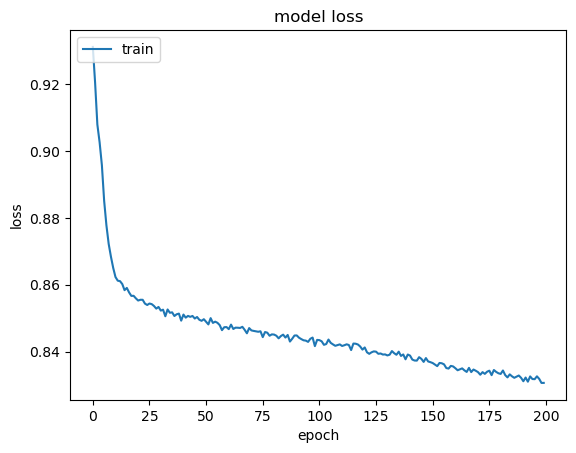

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save('models/rnn_15_2.h5')
#load model
#model = keras.models.load_model('models/rnn_15.h5')

## Part 3 - Making the predictions and visualising the results

### Getting the predicted stock price

In [16]:
inputs = dataset[len(dataset) - len(dataset_test) - timestamps+1:].drop(["position"], axis=1)
inputs = sc.transform(inputs)
X_test = []
for i in range(timestamps, len(inputs)+1):
    X_test.append(inputs[i-timestamps:i])
X_test = np.array(X_test)
predicted_position = model.predict(X_test)
print(predicted_position)
print(inputs.shape)
print(X_test.shape)

32/32 [==============================] - 3s 33ms/step
[[ 1.54037759e-01]
 [ 4.99392658e-01]
 [ 1.66571900e-01]
 [ 4.51652259e-01]
 [-7.25250661e-01]
 [ 1.10648282e-01]
 [ 2.80461699e-01]
 [ 4.52140480e-01]
 [-6.33562744e-01]
 [ 5.30493855e-01]
 [ 2.08539218e-01]
 [ 3.22247446e-01]
 [ 1.45898625e-01]
 [ 2.92371154e-01]
 [ 2.93213390e-02]
 [-2.43935257e-01]
 [-6.86302960e-01]
 [ 3.01103175e-01]
 [ 5.05253911e-01]
 [-6.29360497e-01]
 [ 6.23212039e-01]
 [-3.87473077e-01]
 [ 4.81184959e-01]
 [ 2.52360523e-01]
 [-7.28842556e-01]
 [ 3.02210450e-01]
 [-7.87595987e-01]
 [ 2.95224875e-01]
 [ 3.59937876e-01]
 [ 7.37445891e-01]
 [ 2.84034222e-01]
 [-3.65049005e-01]
 [-4.85752448e-02]
 [-4.30529863e-01]
 [ 1.19571639e-02]
 [ 4.22308296e-01]
 [-4.59768265e-01]
 [ 5.95214784e-01]
 [ 3.72030199e-01]
 [ 3.42760861e-01]
 [ 5.55704832e-01]
 [-7.47347414e-01]
 [-9.06822011e-02]
 [ 1.67418078e-01]
 [ 6.15974724e-01]
 [-1.78528383e-01]
 [-6.35971963e-01]
 [ 3.42756927e-01]
 [ 4.95597839e-01]
 [ 2.17941523e-

In [18]:
real_position = dataset_test["position"].values
print(real_position)
print(real_position.shape)

[-1.  1.  1.  1. -1. -1.  0.  1. -1.  1.  0.  0. -1. -1.  1.  1. -1. -1.
  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  0.  1.  1. -1. -1.  1. -1.  1.
 -1.  0.  1.  0.  1. -1. -1.  1.  0.  1. -1.  1.  0.  0.  1. -1.  0.  1.
  1.  0.  0.  1.  1. -1.  0.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.
  1. -1.  0. -1.  1.  0.  1. -1.  0. -1.  1. -1. -1.  1. -1.  1. -1.  1.
 -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  0. -1.  1.  1. -1. -1. -1.
  1.  0.  1. -1.  1.  1. -1.  0.  1.  0. -1.  1.  1. -1. -1.  0.  1. -1.
 -1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.
  1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  0.  1.  1.
 -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  0.  1. -1.
  1.  0. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.
  0. -1.  0.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.
  1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  1.
  1.  1.  0. -1.  1. -1. -1. -1.  1.  1. -1. -1.  1

### Visualising the results

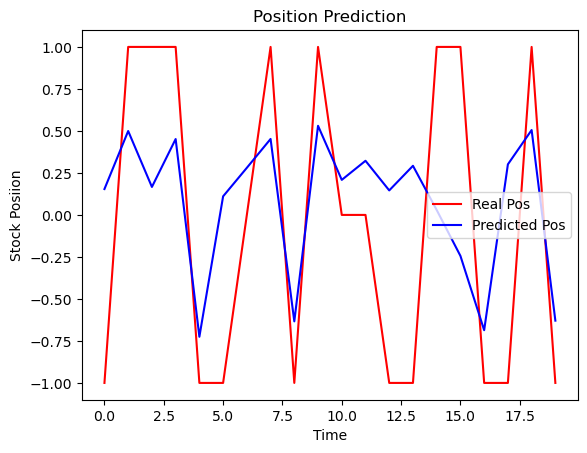

In [19]:
plt.plot(real_position[0:20], color = 'red', label = 'Real Pos')
plt.plot(predicted_position[0:20], color = 'blue', label = 'Predicted Pos')
plt.title('Position Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Posiion')
plt.legend()
plt.show()

In [67]:
limit = 0.65
pred_pos = [0]* len(real_position)
predicted_position = predicted_position.flatten()
pred_pos = np.where( predicted_position  > limit, 1 , pred_pos)
pred_pos = np.where( predicted_position  < -limit, -1 , pred_pos)
#np.unique(pred_pos)
#np.count_nonzero(pred_pos == -1)
results = np.where( pred_pos  == real_position, 1 , 0)
hits = np.count_nonzero(results==1)
print("hits = {}".format(hits)) 
print("percentage of hits {}%".format(  hits/len(real_position)*100  ))
print("--------------------------")
good_long_trades = np.where( np.logical_and(pred_pos  == real_position, pred_pos == 1), 1 , 0)
good_short_trades = np.where( np.logical_and(pred_pos  == real_position, pred_pos == -1), 1 , 0)
print("good long positions = {}".format(np.sum(good_long_trades))) 
print("good short positions = {}".format(np.sum(good_short_trades))) 

bad_long_trades = np.where( np.logical_and(pred_pos  == 1, real_position == -1), 1 , 0)
bad_short_trades = np.where( np.logical_and(pred_pos  == -1, real_position == 1), 1 , 0)
print("bad long positions = {}".format(np.sum(bad_long_trades))) 
print("bad short positions = {}".format(np.sum(bad_short_trades))) 

false_long_trades = np.where( np.logical_and(pred_pos  == 1, real_position == 0), 1 , 0)
false_short_trades = np.where( np.logical_and(pred_pos  == -1, real_position == 0), 1 , 0)
print("false long positions = {}".format(np.sum(false_long_trades))) 
print("false short positions = {}".format(np.sum(false_short_trades))) 

total_good_positions = np.sum(good_long_trades) + np.sum(good_short_trades)
total_positions =  np.sum(np.where( pred_pos  != 0, 1 , 0))
print("--------------------------")
print("total good positions are {}".format(total_good_positions))
print("total positions made are {}".format(total_positions))
print("accuracy of positions made is {}%".format(  round(total_good_positions/total_positions,3)*100 ))

false_negative = np.sum(np.where( np.logical_and(pred_pos  == 0, real_position != 0), 1 , 0))
print("total false neutral positions are {}({}% of total period)".format(false_negative, round(false_negative/len(real_position)*100, 3)))


hits = 217
percentage of hits 21.7%
--------------------------
good long positions = 2
good short positions = 55
bad long positions = 2
bad short positions = 9
false long positions = 0
false short positions = 3
--------------------------
total good positions are 57
total positions made are 71
accuracy of positions made is 80.30000000000001%
total false neutral positions are 769(76.9% of total period)


In [68]:
dataset.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'Taker Buy Base Asset Volume',
       'Taker Buy Quote Asset Volume', 'Close|SMA|5', 'Close|SMA|13',
       'Close|EWMA|a5', 'Close|EWMA|a8', 'Close|SMA|10',
       'Close|BBs|1.5|10|Lower', 'Close|BBs|1.5|10|Upper',
       'Close|BBs|1.5|10|Distance', 'Close_MACD_12_26_9',
       'Close_MACDh_12_26_9', 'Close_MACDs_12_26_9', 'Close_RSI_14',
       'CDL_HAMMER', 'CDL_INVERTEDHAMMER', 'CDL_DOJI_10_0.1',
       'CDL_DRAGONFLYDOJI', 'CDL_GRAVESTONEDOJI', 'Close_EBSW',
       'Close_High_Low_ADX_14', 'Close_High_Low_DMP_14',
       'Close_High_Low_DMN_14', 'Close_High_Low_Volume_KVO_34_55_13',
       'Close_High_Low_Volume_KVOs_34_55_13', 'Close_Volume_OBV', 'position'],
      dtype='object')

In [70]:
dataset[["High", "Open"]]

,High,Open
Date,,
2022-10-31 17:44:00,20644.9,20644.9
2022-10-31 17:45:00,20644.9,20640.0
2022-10-31 17:46:00,20644.9,20641.2
2022-10-31 17:47:00,20644.9,20640.0
2022-10-31 17:48:00,20644.9,20512.0
...,...,...
2022-12-19 07:12:00,16789.0,16787.0
2022-12-19 07:13:00,16789.0,16789.0
2022-12-19 07:14:00,16790.0,16789.0
